## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [5]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import torch

sys.path.append("..")
import models_mae

### Define utils

In [6]:
# define the utils
poplulus_mean = np.array([0.1767787, 0.19072463, 0.20309546, 0.2463202])
poplulus_std = np.array([0.04486727, 0.05505818, 0.06724718, 0.07047508])


def prepare_model(chkpt_dir, arch="mae_vit_large_patch16"):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location="cpu")
    msg = model.load_state_dict(checkpoint["model"], strict=False)
    print(msg)
    return model


def show_populus_image(image, title=""):
    # image is [H, W, 4]
    assert image.shape[2] == 4
    image = image[:, :, [3, 2, 1]]

    image = image * poplulus_std[-1:-4:-1] + poplulus_mean[-1:-4:-1]

    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis("off")
    return


def run_one_image(img, model, stem):
    x = torch.tensor(img)
    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum("nhwc->nchw", x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)

    y = model.unpatchify(y)
    y = torch.einsum("nchw->nhwc", y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0] ** 2 * 4)  # (N, H*W, p*p*4)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum("nchw->nhwc", mask).detach().cpu()

    x = torch.einsum("nchw->nhwc", x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams["figure.figsize"] = [24, 24]

    plt.subplot(1, 4, 1)
    show_populus_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_populus_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_populus_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_populus_image(im_paste[0], "reconstruction + visible")

    plt.savefig(stem, bbox_inches="tight", dpi=265)
    # plt.show()

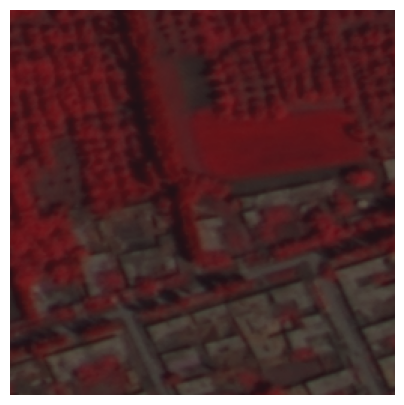

In [7]:
# populus
# "E:\Populus_MAE_dataset\image-batch-1\test\tile_00016292.tif" 这张图表现值得期待

file = Path(r"E:\Populus_MAE_dataset\image-batch-1\test\tile_00016292.tif")

with rasterio.open(file) as src:
    img = src.read().transpose(1, 2, 0) / 255.0

# normalize by ImageNet mean and std
img = img - poplulus_mean
img = img / poplulus_std

plt.rcParams["figure.figsize"] = [5, 5]
show_populus_image(torch.tensor(img))


### Load an image

C:\Users\xianyu\AppData\Local\Temp\ipykernel_14788\177880485.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location="cpu")


<All keys matched successfully>
checkpoint-0.pth
<All keys matched successfully>
checkpoint-100.pth
<All keys matched successfully>
checkpoint-120.pth
<All keys matched successfully>
checkpoint-140.pth
<All keys matched successfully>
checkpoint-160.pth
<All keys matched successfully>
checkpoint-180.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020982037261247644..0.4179311828043556].


<All keys matched successfully>
checkpoint-20.pth
<All keys matched successfully>
checkpoint-200.pth
<All keys matched successfully>
checkpoint-220.pth
<All keys matched successfully>
checkpoint-240.pth
<All keys matched successfully>
checkpoint-260.pth
<All keys matched successfully>
checkpoint-280.pth
<All keys matched successfully>
checkpoint-300.pth
<All keys matched successfully>
checkpoint-320.pth
<All keys matched successfully>
checkpoint-340.pth
<All keys matched successfully>
checkpoint-40.pth
<All keys matched successfully>
checkpoint-60.pth
<All keys matched successfully>
checkpoint-80.pth


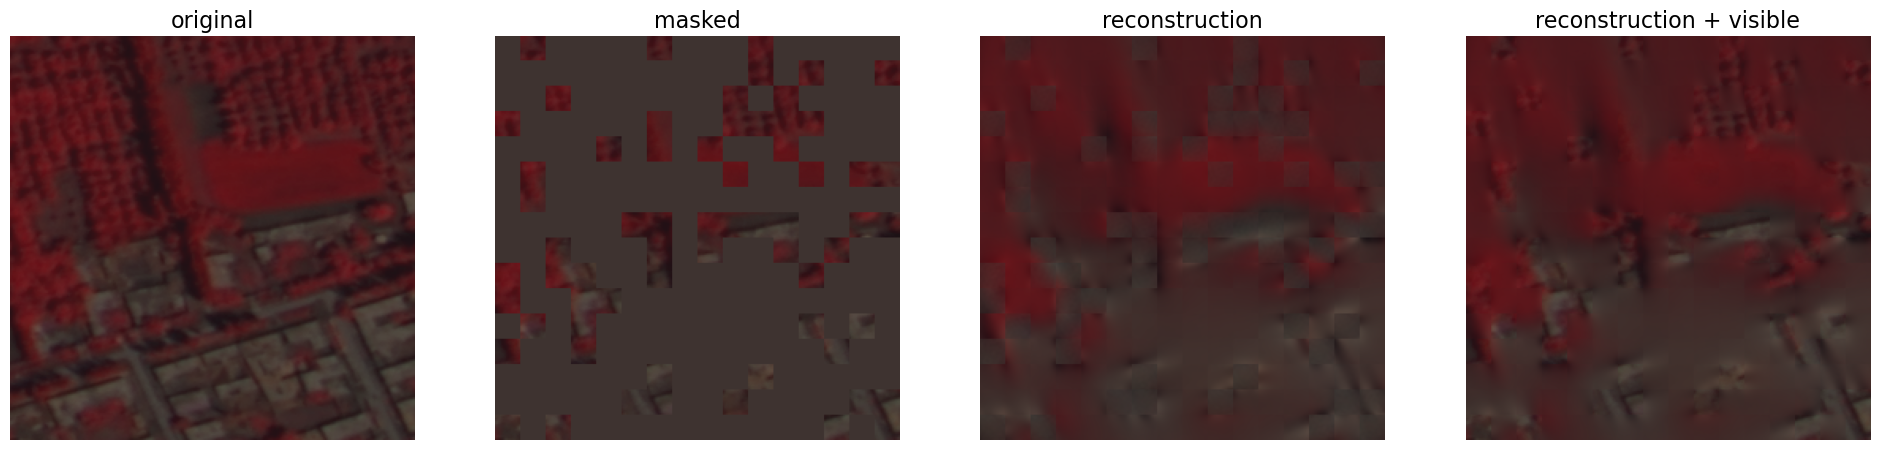

In [8]:
assert img.shape == (256, 256, 4)
Path(file.stem).mkdir(exist_ok=True)

model_name = "mae_vit_huge_patch16_populus"
# make random mask reproducible (comment out to make it change)
# print("MAE with pixel reconstruction:")

for i in Path(r"C:\Users\xianyu\Documents\Source\proj_rs_mae\output_dir").glob("*.pth"):
    torch.manual_seed(114514)
    model_mae = prepare_model(i, model_name)
    model_mae.eval()
    print(i.name)
    run_one_image(img, model_mae, Path(file.stem) / (f"{model_name}-{i.stem[11:]}.png"))